In [ ]:
from toolkit.nlp import TextDataset
from transformers import AutoTokenizer
from toolkit.enums import Split
from toolkit.nlp import NLPTrainingConfig
from load_data_fn import load_data_fn

DEFAULT_PAD_TOKEN = "[PAD]"

tokenizer =  AutoTokenizer.from_pretrained("pretrained_models/baichuan2-13b-chat", trust_remote_code=True)

if tokenizer.pad_token is None:
    print(f"Adding pad token {DEFAULT_PAD_TOKEN}")
    tokenizer.add_special_tokens(dict(pad_token=DEFAULT_PAD_TOKEN))

train_dataset = TextDataset.from_file(
    "data/hot_finetune_data/train.json",
    tokenizer,
    split=Split.TRAINING,
    configs=NLPTrainingConfig(train_batch_size=64),
    load_data_fn=load_data_fn,
)

In [ ]:

print(tokenizer.decode(train_dataset[0]['model_input']['input_ids']))

In [ ]:
print(train_dataset[0]['labels'])
print(tokenizer.decode(abs(train_dataset[0]['labels']), skip_special_tokens=False))

In [ ]:
tokenizer("你好呀</s>", add_special_tokens=True)

In [ ]:
32*0.04

In [ ]:
round(-2.6)

In [ ]:
import time
from pathlib import Path
import deepspeed
import hjson
import numpy as np
import toolkit
import torch
import torch.distributed as dist
from fire import Fire
from toolkit import getLogger
from toolkit.enums import Split
from toolkit.metric import MetricDict
from toolkit.nlp import TextDataset
from toolkit.training import Trainer, initialize
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedTokenizer,
    CONFIG_MAPPING,
)
from myconfig import MyTrainingConfig
from load_data_fn import load_data_fn
from toolkit.training.dataloader import get_dataloader
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"
local_rank=0
logger = getLogger(__name__, "/dev/null")
config = MyTrainingConfig(parallel_mode="deepspeed" ,
    deepspeed_config ="./ds_zero3_offload_mod.hjson" ,
    dashboard ="tensorboard" ,
    model_dir ="./baichuan-13b-chat" ,
    train_file_path ="./data/hot_finetune_data/train.json" ,
    train_batch_size =8 ,
    gradient_accumulation_steps =1 ,
    seed =0 ,
    fp16 =True ,
    epochs =16 ,
    opt_lr ="1e-4" ,
    sch_warmup_ratio_steps =0.03 ,
    opt_weight_decay =0 ,
    ddp_timeout =30000 ,
    torch_dtype ="float16" ,
    logging_steps =1 ,
    padding_side ="left" ,)

def load_tokenizer() -> PreTrainedTokenizer:
    # * Load tokenizer
    tokenizer_kwargs = {
        "cache_dir": config.cache_dir,
        "use_fast": config.use_fast_tokenizer,
        "revision": config.model_revision,
        "use_auth_token": True if config.use_auth_token else None,
    }
    if config.model_dir:
        tokenizer = AutoTokenizer.from_pretrained(
            config.model_dir, **tokenizer_kwargs, trust_remote_code=True
        )
    else:
        raise ValueError(
            "You are instantiating a new tokenizer from scratch. This is not supported by this script."
            "You can do it from another script, save it, and load it from here, using --tokenizer_name."
        )
    # * resize embedding
    if tokenizer.pad_token is None:
        print(f"Adding pad token {DEFAULT_PAD_TOKEN}")
        tokenizer.add_special_tokens(dict(pad_token=DEFAULT_PAD_TOKEN))
    logger.info(f"len(tokenizer):{len(tokenizer)}")
    if dist.is_initialized():
        dist.barrier()
    return tokenizer

def load_dataset(tokenizer: PreTrainedTokenizer) -> tuple:
    # * Load training data, development data and test data
    train_dataset = TextDataset.from_file(
        config.train_file_path,
        tokenizer,
        split=Split.TRAINING,
        configs=config,
        load_data_fn=load_data_fn,
    )
    try:
        val_dataset = TextDataset.from_file(
            config.val_file_path,
            tokenizer,
            split=Split.VALIDATION,
            configs=config,
            load_data_fn=load_data_fn,
        )
    except TypeError as e:
        if local_rank == 0:
            logger.warning(e)
        val_dataset = None
    try:
        test_dataset = TextDataset.from_file(
            config.test_file_path,
            tokenizer,
            split=Split.TEST,
            configs=config,
            load_data_fn=load_data_fn,
        )
    except TypeError as e:
        if local_rank == 0:
            logger.warning(e)
        test_dataset = None
    if dist.is_initialized():
        dist.barrier()
    return train_dataset, val_dataset, test_dataset

def load_model(tokenizer) -> deepspeed.DeepSpeedEngine:
    start = time.time()
    # * Load model config
    model_kwargs = {
        "cache_dir": config.cache_dir,
        "revision": config.model_revision,
        "use_auth_token": True if config.use_auth_token else None,
    }
    if config.model_dir:
        model_config = AutoConfig.from_pretrained(
            config.model_dir, **model_kwargs, trust_remote_code=True
        )
    else:
        model_config = CONFIG_MAPPING[config.model_type]()
        logger.warning("You are instantiating a new config instance from scratch.")
        if config.config_overrides is not None:
            logger.info(f"Overriding config: {config.config_overrides}")
            model_config.update_from_string(config.config_overrides)
            logger.info(f"New config: {config}")
    # * Load model
    logger.debug(f"local_rank {local_rank}: Loading model ...")
    if config.model_dir:
        torch_dtype = (
            config.torch_dtype
            if config.torch_dtype in ["auto", None]
            else getattr(torch, config.torch_dtype)
        )
        model = AutoModelForCausalLM.from_pretrained(
            config.model_dir,
            from_tf=bool(".ckpt" in config.model_dir),
            config=model_config,
            cache_dir=config.cache_dir,
            revision=config.model_revision,
            use_auth_token=True if config.use_auth_token else None,
            torch_dtype=torch_dtype,
            low_cpu_mem_usage=False,
            trust_remote_code=True,
        )
    else:
        model = AutoModelForCausalLM.from_config(config)
        n_params = sum({p.data_ptr(): p.numel() for p in model.parameters()}.values())
        logger.info(
            f"Training new model from scratch - Total size={n_params/2**20:.2f}M params"
        )
    embedding_size = model.get_input_embeddings().weight.shape[0]
    if len(tokenizer) != embedding_size:
        logger.info("resize the embedding size by the size of the tokenizer")
        model.resize_token_embeddings(len(tokenizer))
    ds_model=model
    # if config.parallel_mode == "deepspeed":
    #     deepspeed_config = hjson.load(open(config.deepspeed_config, "r"))
    #     config.set_deepspeed(deepspeed_config)
    #     ds_model, _, _, _ = deepspeed.initialize(model=model, config=deepspeed_config)
    end = time.time()
    logger.debug(f"local_rank {local_rank}: Loading model takes {end - start:.2f} sec.")
    return ds_model

# * Loading tokenizer
tokenizer = load_tokenizer()

# * load dataset
dataset_train, val_dataset, test_dataset = load_dataset(tokenizer)

# *load model
model = load_model(tokenizer)

dataloader_train, sampler = get_dataloader(
            dataset_train, config, Split.TRAINING, collate_fn=dataset_train.collate_fn, shuffle=config.shuffle
        )

In [ ]:
for batch in dataloader_train:
    output = model(**batch, max_new_tokens=20)
    break

# dataset

In [1]:
from transformers import AutoTokenizer
from build_dataset import MyDataset
import os
from pathlib import Path
tokenizer =  AutoTokenizer.from_pretrained("pretrained_models/baichuan2-13b-chat", trust_remote_code=True)
path = Path("data/hot_finetune_data/")
files = [os.path.join(path,file.name) for file in path.glob("*.json")]
dataset = MyDataset(files, tokenizer, 2048)

/root/codes/train_llms/ngram.py:31: DeprecationWarning: invalid escape sequence '\s'
  EN_PART_RE = re.compile("[\s\u0021-\u007f]+")


In [2]:
len(dataset)

150

In [6]:
from toolkit.training import get_dataloader
from toolkit.enums import Split
from toolkit.nlp import NLPTrainingConfig

In [13]:
dataloader, _ = get_dataloader(dataset, NLPTrainingConfig(train_batch_size=8), Split.TRAINING, collate_fn=dataset.collate_fn)

In [14]:
for batch in dataloader:
    break

# deepspeed

In [3]:
from deepspeed import DeepSpeedConfig
ds_config = {
    "fp16": {
        "enabled": False
    },
    "bf16": {
        "enabled": False
    },
    "train_batch_size":2
}
config = DeepSpeedConfig(ds_config)

# construct dataset

In [2]:
import pandas

df = pandas.read_json('data/hot_finetune_data/train_v6.json', lines=True)


In [5]:
dev = df.sample(100, replace=False)
train = df.drop(dev.index)

In [6]:
dev.info()
train.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 127 to 5129
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  100 non-null    object
 1   input        100 non-null    object
 2   output       100 non-null    object
 3   query        71 non-null     object
dtypes: object(4)
memory usage: 3.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 5962 entries, 0 to 6061
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  5962 non-null   object
 1   input        5962 non-null   object
 2   output       5962 non-null   object
 3   query        3890 non-null   object
dtypes: object(4)
memory usage: 232.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6062 entries, 0 to 6061
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  6062 non-null   o

In [11]:
d = 'data/hot_finetune_data'
from pathlib import Path

d = Path(d)

train_dir = d/'train'
dev_dir = d/'dev'

train_dir.mkdir(exist_ok=True)
dev_dir.mkdir(exist_ok=True)

train.to_json(train_dir/"all.json", orient="records", lines=True, force_ascii=False)
dev.to_json(dev_dir/"all.json", orient="records", lines=True, force_ascii=False)

In [7]:
from transformers import AutoConfig
import torch

config = AutoConfig.from_pretrained("./pretrained_models/baichuan2-13b-chat/", trust_remote_code=True)
print(config.vocab_size)

torch_dtype = torch.float16
from_pretrained_kwargs = dict(
    from_tf=False,
    cache_dir=None,
    revision="main",
    use_auth_token=True,
    torch_dtype=torch_dtype,
    low_cpu_mem_usage=False,
    trust_remote_code=True,
)

125696


# test rouge

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from toolkit.metric import rouge

pred = ["你好吗", "你多大", "abcdefg"]
tgt=[["好吗", "你好吗"], ["你", "你多大a"], ["bfg", "abcdefg"]]

rouge(pred, tgt, 'zh',('rougeL', 'rouge1','rouge2'))

Calculating rouge:   0%|          | 0/3 [00:00<?, ?it/s]

{'rougeL': 0.9523809552192688, 'rouge1': 0.9523809552192688, 'rouge2': 0.9333333373069763}

# test bleu self-bleu

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
preds = 'the cat is on the mat'.split()
target = ['there is a cat on the mat'.split()]
chencherry = SmoothingFunction()
sentence_bleu(target, preds, [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)],smoothing_function=chencherry.method1)

[0.7054014374088451,
 0.4887164517296948,
 0.36973494931036327,
 0.19433094436376075]

In [3]:
preds = ['the cat is on the mat'.split(), 'the cat is on the mat'.split()]
target = [['a cat is on the mat'.split()], ['there is a cat on the mat'.split()]]
chencherry = SmoothingFunction()
# print(sentence_bleu(target, preds, [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)],smoothing_function=chencherry.method1))
print(corpus_bleu(target, preds, [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)],smoothing_function=chencherry.method1))

[0.7667036788577695, 0.6505696445772021, 0.5795916624148455, 0.49432603195143127]


In [4]:
from toolkit.metric import bleu
preds = ['the cat is on the mat', 'the cat is on the mat']
target = ['a cat is on the mat', 'there is a cat on the mat']
print(bleu(preds, target, 'en',('bleu1', 'bleu2', 'bleu3', 'bleu4'), smoothing_level=1))
print(bleu(preds, target, 'en',weights= [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)], smoothing_level=1))

/usr/local/python3.11.2/lib/python3.11/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")


{'bleu1': 0.7667036788577695, 'bleu2': 0.6505696445772021, 'bleu3': 0.5795916624148455, 'bleu4': 0.49432603195143127}
[0.7667036788577695, 0.6505696445772021, 0.5795916624148455, 0.49432603195143127]


In [5]:
from toolkit.metric import self_bleu_one_set

print(self_bleu_one_set(['the cat is on the mat', 'a cat is on the mat', 'there is a cat on the mat'], language='en', smoothing_level=1))
print(self_bleu_one_set(['the cat is on the mat', 'a dog is running', 'birds can fly in sky freely'], language='en', smoothing_level=1))

print(self_bleu_one_set(['the cat is on the mat', 'a cat is on the mat', 'there is a cat on the mat'], language='en', weights=(1./4., 1./4., 1./4., 1./4.),smoothing_level=1))
print(self_bleu_one_set(['the cat is on the mat', 'a dog is running', 'birds can fly in sky freely'], language='en', weights=(1./4., 1./4., 1./4., 1./4.),smoothing_level=1))

{'self-bleu4': 0.5927691099058979}
{'self-bleu4': 0.9838113864342718}
[0.5927691099058979]
[0.9838113864342718]


In [6]:
from toolkit.metric import self_bleu_one_set

print(self_bleu_one_set(['the cat is on the mat', 'a cat is on the mat', 'there is a cat on the mat'],'en',('bleu1', 'bleu2', 'bleu3', 'bleu4'), smoothing_level=1 ))
print(self_bleu_one_set(['the cat is on the mat', 'a dog is running', 'birds can fly in sky freely'],'en',('bleu1', 'bleu2', 'bleu3', 'bleu4'), smoothing_level=1 ))

{'self-bleu1': 0.19999999999999996, 'self-bleu2': 0.3492086265440315, 'self-bleu3': 0.46718654768645307, 'self-bleu4': 0.5927691099058979}
{'self-bleu1': 0.9375, 'self-bleu2': 0.9780735495173243, 'self-bleu3': 0.9831223404705209, 'self-bleu4': 0.9838113864342718}


In [7]:
from toolkit.metric import self_bleu

print(self_bleu([['the cat is on the mat', 'a cat is on the mat', 'there is a cat on the mat'], ['the cat is on the mat', 'a dog is running', 'birds can fly in sky freely']], 'en', smoothing_level=1))
print(self_bleu([['the cat is on the mat', 'a cat is on the mat', 'there is a cat on the mat'], ['the cat is on the mat', 'a dog is running', 'birds can fly in sky freely']],  'en', bleu_keys=('bleu1', 'bleu2', 'bleu3', 'bleu4'), smoothing_level=1))

  0%|          | 0/2 [00:00<?, ?it/s]

{'self-bleu4': 0.7882902481700849}


  0%|          | 0/2 [00:00<?, ?it/s]

{'self-bleu1': 0.56875, 'self-bleu2': 0.6636410880306779, 'self-bleu3': 0.725154444078487, 'self-bleu4': 0.7882902481700849}


# test MetricDict

In [190]:
from toolkit.metric import MetricDict

m1 = MetricDict(bleu1=90, bleu2=45)
m2 = MetricDict(bleu1=80, bleu2=40)

print(2*m2*2)
print(1/m2/2)
print(m2+1.0)
print(1.+m2)
print(m2-1.0)
print(1.-m2)

{'bleu1': 320, 'bleu2': 160}
{'bleu1': 0.00625, 'bleu2': 0.0125}
{'bleu1': 81.0, 'bleu2': 41.0}
{'bleu1': 81.0, 'bleu2': 41.0}
{'bleu1': 79.0, 'bleu2': 39.0}
{'bleu1': -79.0, 'bleu2': -39.0}


# 读取tensorboard数据

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = "runs/tensorboard/hot_finetune_data/baichuan-13b-chat/root/paddlejob/workspace/env_run/baichuan-13b-chat/baseline-data_v2"
event_acc = EventAccumulator(log_dir)

In [3]:
event_acc.Reload()

In [4]:
tags = event_acc.Tags()
tags

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': [],
 'distributions': [],
 'tensors': ['training/loss',
  'VALIDATION/rouge1',
  'VALIDATION/rouge2',
  'VALIDATION/rougeL',
  'VALIDATION/self-bleu1',
  'VALIDATION/self-bleu2',
  'VALIDATION/self-bleu3',
  'VALIDATION/self-bleu4'],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [5]:
data = event_acc.Tensors("VALIDATION/rougeL")

In [6]:
data[0].tensor_proto.float_val[0]

28.670000076293945

In [7]:
steps_rougel = [event.step for event in event_acc.Tensors("VALIDATION/rougeL")]
rougeL = [event.tensor_proto.float_val[0] for event in event_acc.Tensors("VALIDATION/rougeL")]

steps_self_bleu = [event.step for event in event_acc.Tensors("VALIDATION/self-bleu4")]
self_bleu = [event.tensor_proto.float_val[0] for event in event_acc.Tensors("VALIDATION/self-bleu4")]
self_bleu = [100-value for value in self_bleu]

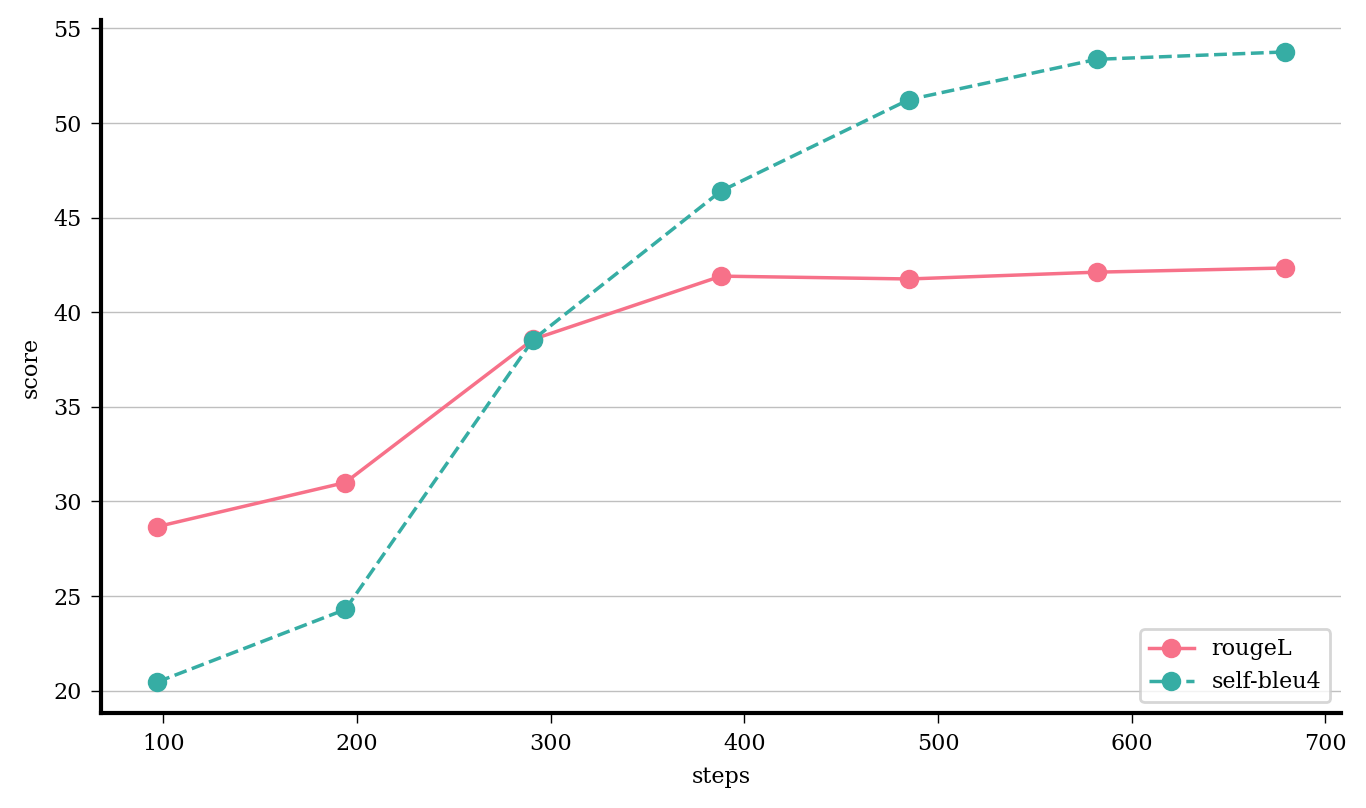

In [14]:
from toolkit.chart import LineChart

chart = LineChart(dpi=200)

chart.draw([steps_rougel, steps_self_bleu], [rougeL, self_bleu], line_label=['rougeL', "self-bleu4"], no_dot=False, xlabel='steps', ylabel='score')
chart.show()

In [24]:
from toolkit.nlp import NLPTrainingConfig

config = NLPTrainingConfig.load("/root/paddlejob/workspace/env_run/outputs/hot_finetune_data/baichuan-13b-chat/mix_general_data_ratio=0.5/10/64/0.0001/0/checkpoints/checkpoint-009")


2023-10-30 12:23:16,531 <INFO> Configuration: 👻 Custom attributes:
2023-10-30 12:23:16,532 <INFO> Configuration:    cache_dir=None
2023-10-30 12:23:16,533 <INFO> Configuration:    model_revision=main
2023-10-30 12:23:16,533 <INFO> Configuration:    use_fast_tokenizer=True
2023-10-30 12:23:16,534 <INFO> Configuration:    use_auth_token=False
2023-10-30 12:23:16,534 <INFO> Configuration:    preprocessing_num_workers=8
2023-10-30 12:23:16,535 <INFO> Configuration:    max_seq_length=2048
2023-10-30 12:23:16,535 <INFO> Configuration:    deepspeed_config=./ds_zero3_offload.hjson
2023-10-30 12:23:16,536 <INFO> Configuration:    generate_config_file=generate_config.json
2023-10-30 12:23:16,536 <INFO> Configuration:    re_gen_num=2
2023-10-30 12:23:16,537 <INFO> Configuration:    total_steps_num=1460
2023-10-30 12:23:16,537 <INFO> Configuration:    steps_per_epoch=146
2023-10-30 12:23:16,538 <INFO> Configuration:    training_runtime={'cur_step': 1460, 'cur_epoch': 9}
2023-10-30 12:23:16,540 <WA

In [26]:
config.training_runtime

{'cur_step': 1460, 'cur_epoch': 9}

In [ ]:
config.to_dict(flat=True)

In [3]:
from tqdm.auto import tqdm, trange
from random import random, randint
from time import sleep

l = list(range(19))

with tqdm(l) as t:
    for i in t:
        # Description will be displayed on the left
        t.set_description('GEN %i' % i)
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        t.set_postfix(loss=random(), gen=randint(1,999), str='h',
                      lst=[1, 2])
        sleep(0.1)

# with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
#           postfix=["Batch", {"value": 0}]) as t:
#     for i in range(10):
#         sleep(0.1)
#         t.postfix[1]["value"] = i / 2
#         t.update()

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import trange
from time import sleep

for i in trange(4, desc='1st loop'):
    for j in trange(5, desc='2nd loop'):
        for k in trange(50, desc='3rd loop', leave=False):
            sleep(0.01)

In [17]:
print(f"_{12:<5d}_")

_12   _


In [16]:
'abc'.center(5)

' abc '